## Блок импорта библиотек

In [ ]:
# Подключить библиотеки для мат обработки данных и генерации случайных данных
import numpy as np
import math

# Подключить библиотеки для работы с датой/временем
from datetime import datetime
import time

# Подключить библиотеки для асинхронной работы
import asyncio
# Подключить библиотеки для работы с базой данных redis
import redis
# Подключить библиотеки для работы с JSON
import json

# Подключить библиотеки для работы с виджетами в Jupyter Lab
import ipywidgets as widgets
from   ipywidgets import Output
from IPython.display import display

# -----------------------------------------------------------------------
# Подключить пользовательские модули
# -----------------------------------------------------------------------
import sys
sys.path.append('/home/project/3D-position-2023/py/lib')

# Подключить модуль для подключения к БД Redis
from py.lib.lib_work_redis_rev01_v01 import *
# Подключить модуль для работы с данными IMU сенсоров
from py.lib.lib_calculate_angles_rev01_v02 import *
# Подключить модуль для создания и обновления HTML элементов отображения данных об углах Эйлера
from py.lib.lib_work_html_widget_rev01_v01 import *
# Подключить модуль с оберткой для синхронных функций в стиле setInterval JavaScript
from py.lib.lib_setinterval_rev01_v01 import *

## Блок объявления глобальных переменных модуля

In [ ]:
AccArrRaw  = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит "сырые" данные от Акселерометра
GyroArrRaw = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит "сырые" данные от Гироскопа
MagArrRaw  = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит "сырые" данные от Магнитометра

AccArrAvg  = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит усредненные данные от Акселерометра
GyroArrAvg = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит усредненные данные от Гироскопа
MagArrAvg  = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит усредненные данные от Магнитометра

AccArrAngle  = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит углы Эйлера полученные с от Акселерометра
GyroArrAngle = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит углы Эйлера полученные с помощью Гироскопа
CompArrAngle = [[0,0,0],[0,0,0],[0,0,0]] # массив, хранит углы Эйлера полученные с помощью фильтра слияния

TempArr = [0] # массив, хранит данные от термометра

TimeDeltaAngle = 0 # значение dt для текущей итерации вычисления углов Эйлера

AccLimitData = 500 # максимальное количество значений от Акселерометра для калибровки

AccXcalibration1 = [] # список значений отобранных для калиброво Акселерометра в Положении 1
AccXcalibration2 = [] # список значений отобранных для калиброво Акселерометра в Положении 3
AccYcalibration1 = [] # список значений отобранных для калиброво Акселерометра в Положении 2
AccYcalibration2 = [] # список значений отобранных для калиброво Акселерометра в Положении 4
AccZcalibration1 = [] # список значений отобранных для калиброво Акселерометра в Положении 5
AccZcalibration2 = [] # список значений отобранных для калиброво Акселерометра в Положении 6

StatusCalibration = True # статус калибровки, 'False' - калибровка не завершена, 'True' - калибровка завершена
PosCalibration = 1 # номер положения калибровки
StatusAsyncCode = False # статус выполнения асинхронного кода,  который участвует в калибровке, 'True'- выполняется, 'False - не выполняется

AsyncFuncID = None # дескриптор хранящий ссылку на асинхронную функцию связанную с SetInterval

## Блок синхронизации данных с БД

In [ ]:
'''
        Не системная функция, выполняет синхронизацию данных между БД и переменными блокнота.  
'''
def AsyncReadDataDB() -> None:
        # Считать массив "сырых" данных из БД
        ImuListRawKey = ('AccArrRaw', 'GyroArrRaw', 'MagArrRaw')
        ImuListRawData = [AccArrRaw, GyroArrRaw, MagArrRaw]
        ReadValJSONfromDB( ConnectDB, ImuListRawKey, ImuListRawData )

        # Считать массив  усредненных данных из БД
        ImuListAvgKey = ('AccArrAvg', 'GyroArrAvg', 'MagArrAvg')
        ImuListAvgData = [AccArrAvg, GyroArrAvg, MagArrAvg]
        ReadValJSONfromDB( ConnectDB, ImuListAvgKey, ImuListAvgData )

        # Считать массивы со значениями углов Эйлера из БД
        AngelListKey = ('AccArrAngle', 'GyroArrAngle', 'CompArrAngle')
        AngelListData = [AccArrAngle, GyroArrAngle, CompArrAngle]
        ReadValJSONfromDB( ConnectDB, AngelListKey, AngelListData )

        # Считать массив со значениями температуры IMU из БД
        TempListKey = ('TempArr',)
        TempListData = [TempArr]
        ReadValJSONfromDB( ConnectDB, TempListKey, TempListData )   

        # Считать значение дельты времени обращений к IMU из БД
        TimeDeltaAngleKey = ('TimeDeltaAngle',)
        TimeDeltaAngleData = [TimeDeltaAngle]
        ReadValJSONfromDB( ConnectDB, TimeDeltaAngleKey, TimeDeltaAngleData )

        # Считать значение коэффициента Альфа, используемого при вычисления значений углов Эйлера в фильтре слияния
        AlphaKey = ('AlphaKey',)
        AlphaData = [Alpha]
        ReadValJSONfromDB( ConnectDB, AlphaKey, AlphaData )

In [ ]:
ConnectDB =  ConnectDB() # подключение к базе данных Redis

In [ ]:
# Асинхронная функция-обертка для выполнения стороннего кода в асинхронном режиме
async def AsyncDataDB():
    AsyncFunc = SetInterval( 0.25, AsyncReadDataDB ) # период синхронизации 'ms' и 'fn' чтения данных из БД
    AsyncFunc.start()

await AsyncDataDB()

## Блок считывания данных Акселерометра, Гироскопа, Магнитометра

In [ ]:
# Задать значения режимов работы Акселерометра, Гироскопа, Магнитометра для процедуры калибровки.
# ВНИМАНИЕ: для калибровки все сенсоры переводятся в режим наибольшей чувствительности !
# Что соответствует наименьшему рабочему диапазону.

CONNECT_DB      = ConnectDB # подключение к БД
LIMIT_DATA_ARR  =  50       # задать ограничение на размер массива данных сырых данных, углов Эйлера и т.д.
LIMIT_WIN_ARR   =  4        # задать размер окна усреднения сырых данных от IMU

OPTION_IMU      = { 'GyroFullScale'   : 250\
                    ,'GyroSampleRate' : 50\
                    ,'GyroLowPass'    : 3\
                    ,'AccFullScale'   : 2\
                    ,'AccSampleRate'  : 50\
                    ,'AccLowPass'     : 3\
                    ,'MagSampleRate'  : 50\
                    ,'Isr'            : 137\
                  }

In [ ]:
# Инстанцировать объект ICM20948 IMU сенсора
IMU = CalculateAngles(CONNECT_DB, LIMIT_DATA_ARR, LIMIT_WIN_ARR, OPTION_IMU)

In [ ]:
ASYNC_IMU_INTERVAL  = 0.017 # интервал опроса IMU 

# Код опроса IMU в асинхронном блоке
async def AsyncUpdateIMU():
    AsyncFunc = SetInterval( ASYNC_IMU_INTERVAL, IMU.UpdateAll )
    AsyncFunc.start()

await AsyncUpdateIMU() # запуск опроса IMU

## Блок калибровки Акселерометра

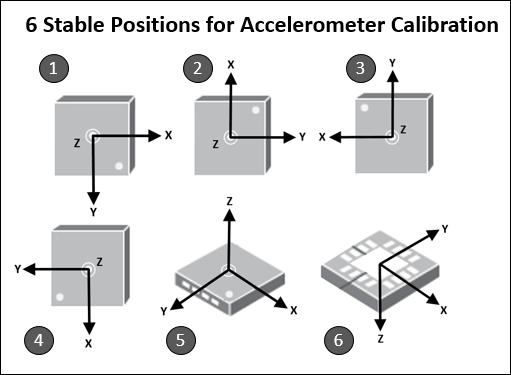

In [ ]:
ASYNC_FILL_ACC_INTERVAL = 0.03 # интервал заполнения калибровочными значениями

In [ ]:
'''
    Не системная функция 'FillArrPos', предназначена для заполнения массивов
    значений Акселерометра на основе которых будет производится калибровка в
    соответствии с калибровочным положением
'''
def FillArrPos(_pos) -> bool:
    match _pos:
        case 1:
            if( len(AccYcalibration1) < AccLimitData ):
                AccYcalibration1.append(AccArrRaw[Y_IND][-1])
                return False
            else:
                return True
        case 2:
            if( len(AccXcalibration2) < AccLimitData ):
                AccXcalibration2.append(AccArrRaw[X_IND][-1])
                return False
            else:
                return True
        case 3:
            if( len(AccYcalibration2) < AccLimitData ):
                AccYcalibration2.append(AccArrRaw[Y_IND][-1])
                return False
            else:
                return True
        case 4:
            if( len(AccXcalibration1) < AccLimitData ):
                AccXcalibration1.append(AccArrRaw[X_IND][-1])
                return False
            else:
                return True
        case 5:
            if( len(AccZcalibration2) < AccLimitData ):
                AccZcalibration2.append(AccArrRaw[Z_IND][-1])
                return False
            else:
                return True
        case 6:
            if( len(AccZcalibration1) < AccLimitData ):
                AccZcalibration1.append(AccArrRaw[Z_IND][-1])
                return False
            else:
                return True

In [ ]:
# Код опроса IMU в асинхронном блоке
async def AsyncFillArrPos(_pos):
    global StatusAsyncCode
    
    AsyncFunc = SetInterval( ASYNC_FILL_ACC_INTERVAL, FillArrPos, _pos )
    StatusAsyncCode = True # взвести флаг сигнализирующий о выполнении асинхронного кода
    AsyncFunc.start()

In [ ]:
'''
    Не системная функция 'ArrPositionCalibrate' выполняет действия по заполнению массивов
    с данными для калибровки Акселерометра для каждого Положения в отдельности FillArrPos
'''
async def ArrPositionCalibrate(_pos):
    if(StatusAsyncCode): return # если ранее уже была запущена асинхронная функция

    match _pos:
        case 1:
            await AsyncFillArrPos(_pos) # запуск
                

In [ ]:
'''
    Не системная функция 'AccCalibrate' выполняет запуск калибровки Акселерометра или
    продолжает если она была начата ранее.
'''
def AccCalibrate(_pos):
    global StatusCalibration
    
    if(StatusCalibration):
        StatusCalibration = False # калибровка начата !

        AccXcalibration1.clear() # очистка массива для калибровки
        AccXcalibration2.clear() # очистка массива для калибровки
        AccYcalibration1.clear() # очистка массива для калибровки
        AccYcalibration2.clear() # очистка массива для калибровки
        AccZcalibration1.clear() # очистка массива для калибровки
        AccZcalibration2.clear() # очистка массива для калибровки
    
    #ArrPositionCalibrate()

In [ ]:
# Создать виджет для вывода, который будет использоваться как всплывающее окно
AccButtonOut = widgets.Output(layout={'border': '1px solid black'})

# Создаем кнопку, которая будет открывать всплывающее окно
AccButton_1 = widgets.Button(layout={'width': '200px'}, description='Калибровка: положение 1')

# Функция, которая будет вызываться при нажатии на кнопку
def AccOnButtonClick(b):
    with AccButtonOut:
        # Очищаем предыдущий вывод в окне, если он есть
        AccButtonOut.clear_output()
        # Выводим сообщение (или любой другой контент)
        print('Калибровка d Положению 1 запущена!')

# Привязываем функцию к событию нажатия на кнопку
AccButton_1.on_click(AccOnButtonClick)

# Отображаем кнопку
display(AccButton_1)

# Отображаем виджет вывода (всплывающее окно). Оно будет изначально пустым.
display(AccButtonOut)

# Блок калибровки углов Гироскопа

# Блок калибровки Магнетометра